---
title: ipympl + widgets embedding
author: Georgios Varnavides
date: 2023/07/30
---

This is an example widget illustrating how to use ipympl (for interactive navigating) as-well as matplotlib widgets for toggling a scalebar on/off.

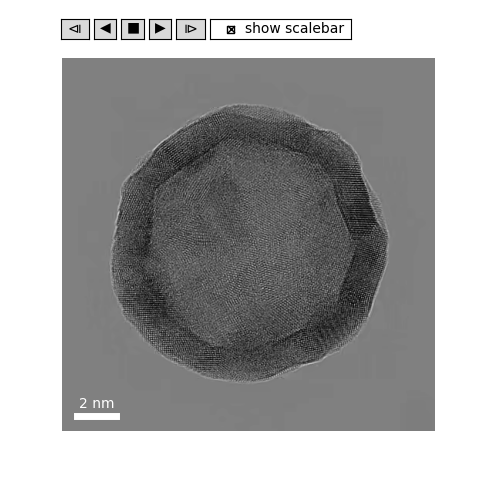

In [2]:
#| label: app:ipympl_widgets_embedding_widget
# Widget for embedding video using ipympl and matplotlib widgets.

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.widgets
import mpl_toolkits.axes_grid1
import imageio as iio

vid = iio.get_reader("data/45grains_compressed.mp4")
num_frames = vid.count_frames()

dpi = 100

plt.ioff()
fig, ax = plt.subplots(figsize=(484/dpi, 484/dpi), dpi=dpi)
ax.axis('off')

array = vid.get_data(0)
im=ax.imshow(array)

scalebar_plot=ax.plot((20,70),(484-20,484-20),lw=5,color='white')
scalebar_text=ax.text((70+20)/2,484-20-10,"2 nm",color='white',ha='center')

class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=10, mini=0, maxi=100,pos=(0.125, 0.92), **kwargs):
        
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        
        FuncAnimation.__init__(self,self.fig, self.func, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
        
    def backward(self, event=None):
        self.forwards = False
        self.start()
        
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
        
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
            
        self.func(self.i)
        self.fig.canvas.draw_idle()

    def update_scalebar(self, label):
        visible = self.button_scalebar.get_status()[0]
        scalebar_plot[0].set_visible(visible)
        scalebar_text.set_visible(visible)
        fig.canvas.draw_idle()

    def setup(self, pos):
        
        playerax = self.fig.add_axes([pos[0],pos[1], 0.60, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        scalebarax = divider.append_axes("right", size="500%", pad=0.05)
        
        self.button_oneback = matplotlib.widgets.Button(playerax, label=u'$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label=u'$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label=u'$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label=u'$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label=u'$\u29D0$')
        self.button_scalebar = matplotlib.widgets.CheckButtons(scalebarax, labels=["show scalebar",],actives=[True,])
        
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.button_scalebar.on_clicked(self.update_scalebar)

def display_frame(index):
    array = vid.get_data(index)
    im.set_data(array)
    fig.canvas.draw_idle()
    return im,

ani = Player(fig, display_frame, maxi=num_frames-1)
plt.show()